In [2]:
from datetime import datetime
import itertools
import json

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import metrics
from torch.utils.data import DataLoader

from utils import data_utils, data_loader, shape_utils
from models import basic_ff

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/throwaway/"

In [3]:
kcm_inputs = data_utils.load_run_input_data(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_run_input_data(RUN_FOLDER, "atb/")

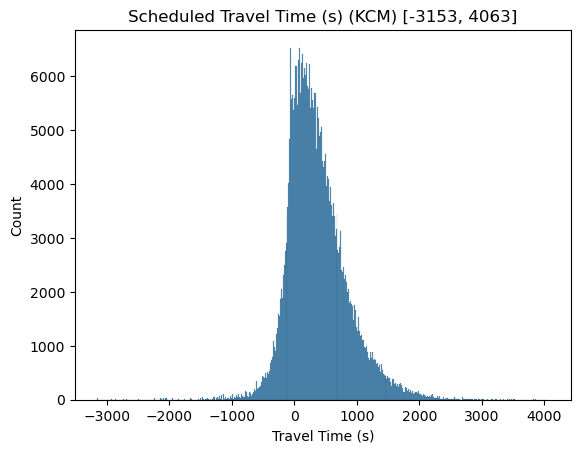

In [4]:
# Histogram of scheduled travel times
plot_data = kcm_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (KCM) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_scheduled_time_dist.png")

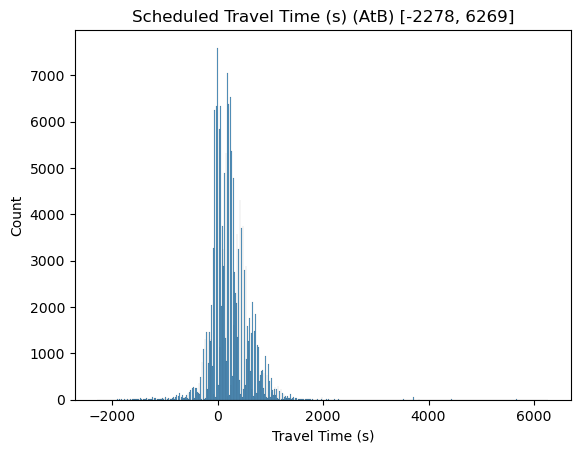

In [5]:
# Histogram of scheduled travel times
plot_data = atb_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (AtB) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_scheduled_time_dist.png")

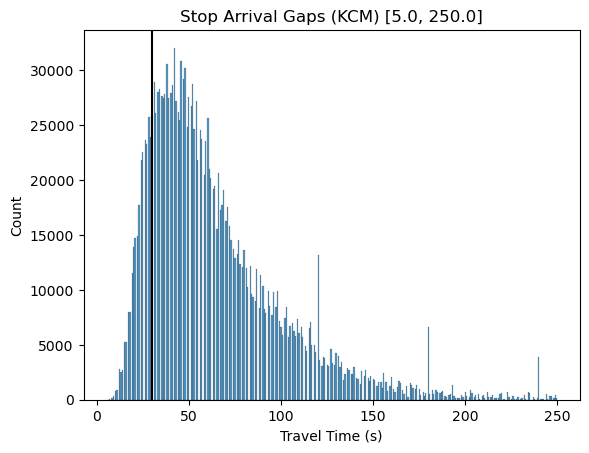

In [6]:
# Histogram of bus travel times in schedule
gtfs_data = kcm_inputs['gtfs_data']
x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (KCM) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/kcm_gtfs_arrival_gaps.png")

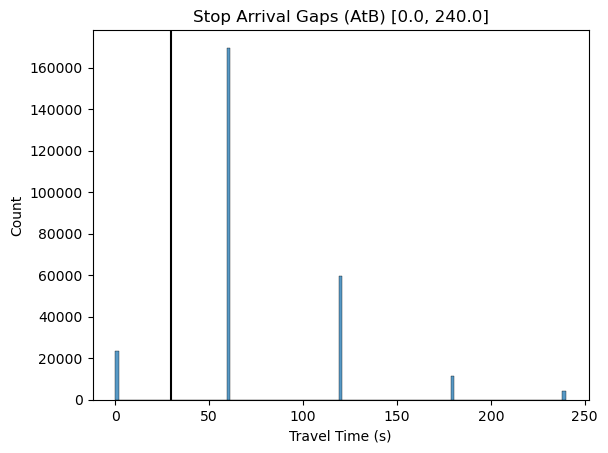

In [7]:
# Histogram of bus travel times in schedule
gtfs_data = atb_inputs['gtfs_data']

x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (AtB) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/atb_gtfs_arrival_gaps.png")

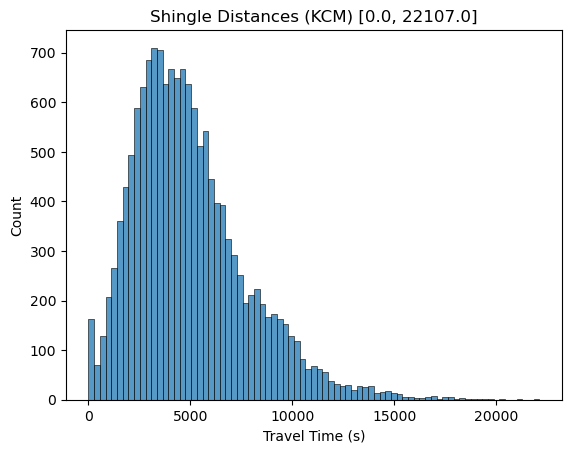

In [8]:
# Shingle distance
metric = kcm_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_shingle_dists.png")

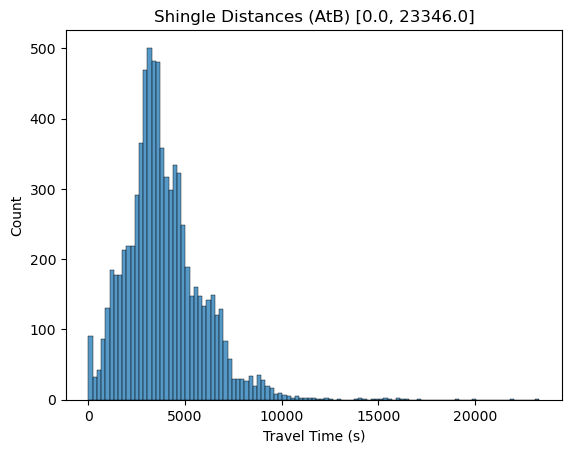

In [9]:
# Shingle distance
metric = atb_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_shingle_dists.png")

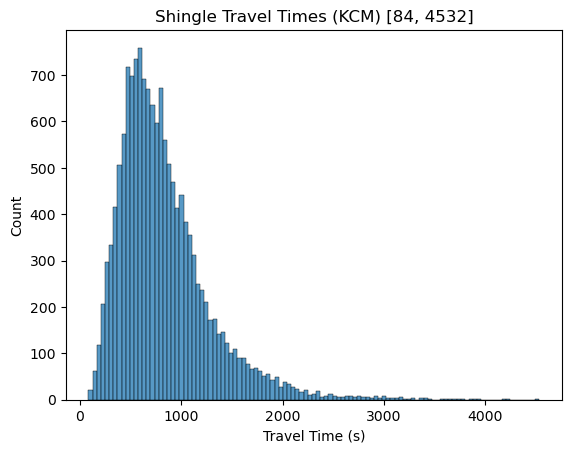

In [10]:
# Shingle travel time
metric = kcm_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_shingle_times.png")

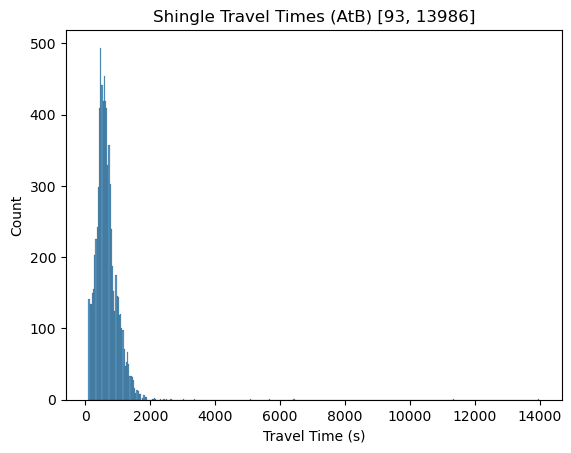

In [11]:
# Shingle travel time
metric = atb_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_shingle_times.png")

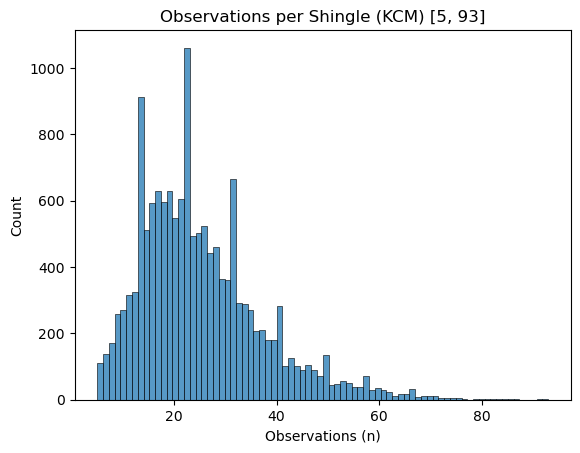

In [12]:
# Points per trajectory
metric = kcm_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/kcm_shingle_n.png")

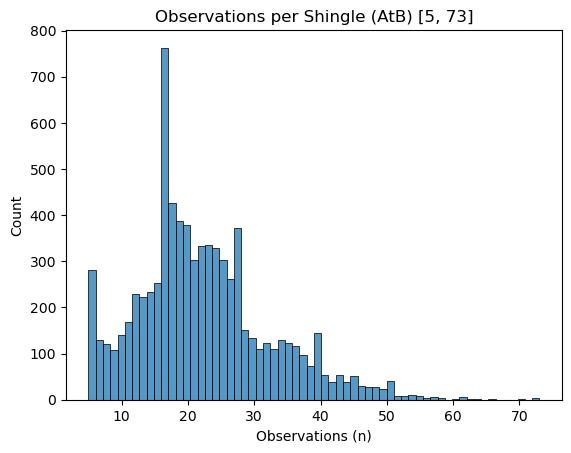

In [13]:
# Points per trajectory
metric = atb_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/atb_shingle_n.png")